In [204]:
from matplotlib import colors    ### 까만 노드 인력척력 djqt는 버전 + grid_to_graph_woblack 함수 추가 + 1.414 주석처리 + np array 로 변경
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.cluster import DBSCAN # conda install -c conda scikit-learn
import pandas as pd # conda install pandas

cmap = colors.ListedColormap(
        [
            '#000000', # 0 검은색
            '#0074D9', # 1 파란색
            '#FF4136', # 2 빨간색
            '#2ECC40', # 3 초록색
            '#FFDC00', # 4 노란색
            '#AAAAAA', # 5 회색
            '#F012BE', # 6 핑크색
            '#FF851B', # 7 주황색
            '#7FDBFF', # 8 하늘색
            '#870C25', # 9 적갈색
            '#505050', # 10 검은색_select
            '#30A4F9', # 11 파란색_select
            #'#FF4136', 
            '#FF7166', # 12 빨간색_select
            '#5EFC70', # 13 초록색_select
            '#FFFC30', # 14 노란색_select
            '#DADADA', # 15 회색_select
            '#F042EE', # 16 핑크색_select
            '#FFB54B', # 17 주황색_select
            '#AFFBFF', # 18 하늘색_select
            '#B73C55'  # 19 적갈색_select
        ])
    #norm = colors.Normalize(vmin=0, vmax=9)
norm = colors.Normalize(vmin=0, vmax=19)

class Pnode :
    def __init__(self, grid, i, j):
        self.color = grid[i][j]
        self.number = self.node_number(len(grid[0]), i, j)
        self.visual_coord = [3 * j, 3 * (len(grid) - i - 1)]  ## coordinate for visualize
        self.coordinate = [j,i]         ## coordinate from the grid
        self.input = 0
        self.output = 0
        self.type = "Pnode"
    def node_number (self, col, i, j): ## start from 0 to (col * row -1) # may not needed
        temp = i * (col) + j
        return temp
    def __str__(self):
        if self.input == 1:
            return f"Pnode: N:{self.number}, I"
        else :
            return f"Pnode: N:{self.number}, O"
class Onode:
    def __init__(self, obj, condition):
        Pnode_list = []
        color_set = set()
        number_set = set()
        for Pnode in obj:
            Pnode_list.append(Pnode)
            color_set.add(Pnode.color)
            number_set.add(Pnode.number)
        self.Pnode_list = Pnode_list
        self.color = color_set            ##questionalbe 
        self.number = number_set  
        self.coordinate = [0,0]
        self.input = 0
        self.output = 0
        self.type = "Onode"
        self.condition = condition
        # [get_coordinate(node) for node in get_center_nodes]    ##questionalbe -> need bbox function first and type will be {(int, int), (int, int) ...}
    def __str__(self):
        pnodes = []
#        for pnode in self.Pnode_list:
#            pnodes.append(pnode.__str__())
        if self.input == 1:
            return f"Onode: N:{self.number}, I"
        else :
            return f"Onode: N:{self.number}, O"
    
class Gnode:
    def __init__(self, node_list): # node_list should contain all the Pnode and Onode from the grid
        self.Node_list = node_list
        color_s = set()
        Pnode_list = []
        Onode_list = []
        for n in node_list:
            if isinstance(n, Pnode):
                color_s.add(n.color)
                Pnode_list.append(n)
            elif isinstance(n, Onode):
                Onode_list.append(n)
        self.color = color_s
        self.Pnode_list = Pnode_list
        self.Onode_list = Onode_list
        self.coordinate = [0,0]
        self.number = 0
        self.input = 0
        self.output = 0
        self.type = "Gnode"
        self.condition = "Gnode"
        # [get_coordinate(node) for node in get_center_nodes]       ## questionable # do we need coornidate for Gnode?
    def __str__(self):
        if self.input == 1:
            return f"Gnode: N:{self.number}, I"
        else :
            return f"Gnode: N:{self.number}, O"

class Vnode:
    def __init__(self, Gnode1, Gnode2): # node_list should contain all the Pnode and Onode from the grid
        self.Gnode_list = [Gnode1, Gnode2]
        self.type = "Vnode"
        self.input = 0
        self.output = 0
        self.color = Gnode1.color.union(Gnode2.color)
        self.Onode_list = [node for node in Gnode1.Onode_list] + [node for node in Gnode2.Onode_list]
        self.Pnode_list = [node for node in Gnode1.Pnode_list] + [node for node in Gnode2.Pnode_list]
    def __str__(self):
        return f"Vnode"

    
class Edge:
    def __init__(self, tag, node1, node2 = None):
        if node2 == None :
            self.node_set = [node1]
        else :
            self.node_set = [node1, node2]
        self.tag = tag       
    def __str__(self):
        n_set = []
        for n in self.node_set:
            n_set.append(n.__str__())
        return f"{n_set, self.tag}"    

def Grid_to_Img(grid): ## function for visualize the image, this function is not a DSL
    plt.axis("off")
    plt.imshow(grid, cmap = cmap, norm = norm)

def Make_NodeList (grid):     ## this function now generate Pnode list from grid
    node_list = []
    if type(grid[0]) == list :
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                temp_node = Pnode(grid, i, j)
                temp_node.color = grid[i][j]
                node_list.append(temp_node)
    return node_list

def Concat_node_list (node_list1, node_list2):
    return node_list1 + node_list2

def Make_Onode (node_list, color_same, dist_dsl, edge_list):
    condition = []
    def edge_list_to_graph(edges):
        graph = {}
        for edge in edges:
            node1, node2 = edge.node_set
            if node1 not in graph:
                graph[node1] = []
            if node2 not in graph:
                graph[node2] = []
            graph[node1].append(node2)
            graph[node2].append(node1)
        return graph
    
    if color_same == True:
        same_color = lambda x1, x2 : True if x1.color == x2.color else False
        node_list1 = node_list
        condition.append("single_color")
    else :
        same_color = lambda x1, x2 : True
        condition.append("multi_color")
        node_list1 = get_background_color_removed(node_list)
    if dist_dsl != None:
        dist_1 = lambda x1, x2 : True if dist_dsl(x1, x2) == 1 else False
        condition.append(dist_dsl.__name__)
    else :
        dist_1 = lambda x1, x2 : True
        condition.append("no_distance")
    same_color_and_dist1 = lambda x1, x2: True if (same_color(x1,x2) == True and dist_1(x1,x2) == True) else False
    s_d_edge_list = Make_edge_list(node_list1, same_color_and_dist1)
    graph = edge_list_to_graph(s_d_edge_list)

    condition = tuple(condition)
    tag = ("get_onode", condition)

    for node in node_list1:
        # if isinstance(node, Onode):
        #     continue
        if node not in graph.keys():
            graph[node] = []
    
    def cluster_graph(graph):
        clusters = []
        visited = set()

        def dfs(node, cluster):
            visited.add(node)
            cluster.add(node)
            for neighbor in graph[node]:
                if neighbor not in visited:
                    dfs(neighbor, cluster)

        for node in graph:
            if node not in visited:
                new_cluster = set()
                dfs(node, new_cluster)
                clusters.append(new_cluster)
                
        return clusters

    clusters = cluster_graph(graph)

    Onode_list = []
    # tag = ("get_onode", None)
    for obj in clusters:
        onode = Onode(obj, condition)
        Onode_list.append(onode)
        for pnode in obj:
            e = Edge(tag, pnode, onode)
            edge_list.append(e)



    return Onode_list, edge_list 

def Make_Gnode (node_list, edge_list):
    gnode = Gnode(node_list)
    gnode_list = []
    tag = ("get_gnode", None)
    for node in node_list:
        e = Edge(tag, gnode, node)
        edge_list.append(e)
    gnode_list.append(gnode)
    return node_list + gnode_list, edge_list

def Make_Vnode (node_list, edge_list):
    gnode_list = []
    for n in node_list:
        if isinstance(n, Gnode):
            gnode_list.append(n)
    assert len(gnode_list) == 2
    vnode = [Vnode(gnode_list[0], gnode_list[1])]
    tag = ("get_vnode", None)
    e1 = Edge(tag, vnode[0], gnode_list[0])
    e2 = Edge(tag, vnode[0], gnode_list[1])
    edge_list.append(e1)
    edge_list.append(e2)
    return node_list + vnode, edge_list

def create_edge_list ():
    return []


    
def create_edge (get_dsl, node1, node2):   ## no self connecting edge
    is_dsl = get_to_is(get_dsl) 
    result = is_dsl(node1, node2)   ## result = (bool (dsl_name, taget))
    if result[0] == False :
        return None
    else :
        tag = result[1]
        edge = Edge(tag, node1, node2)
        return edge



def Make_edge_list (node_list, dsl) :
    edge_list = create_edge_list()
    try :
        if isinstance (dsl(node_list[0]), bool) == True: ## dsl is is_dsl with only one param
            # print("dsl is returning bool type with 1 param")
            tag = (dsl.__name__, None)
            for n1 in node_list:
                if dsl(n1) == True :
                    e = Edge(tag, n1, n1)
                    edge_list.append(e)
            return edge_list
        else :
            pass
    except :
        pass
    try :
        if isinstance (dsl(node_list[0], node_list[0]), bool) == True : ## dsl is is_dsl with two param
            # print("dsl is returning bool type with 2 param")
            tag = (dsl.__name__, None)
            for n1 in node_list:
                for n2 in node_list:
                    if dsl(n1, n2) == True and n1 != n2 :
                        e = Edge(tag, n1, n2)
                        edge_list.append(e)
            return edge_list
    except: 
        pass
    ## dsl is get_dsl
    # print("dsl is get_dsl")
    for n1 in node_list:
        for n2 in node_list:
            e = create_edge(dsl, n1, n2)
            if e != None and n1 != n2:
                edge_list.append(e)
                # print(e)
    return edge_list

def Concat_edge_list (edge_list1, edge_list2):
    return edge_list1 + edge_list2

def get_to_is (get_f):
    param_num = get_f.__code__.co_argcount
    dsl_name = get_f.__name__
    if param_num == 2:
        is_dsl = lambda x1, x2 : (
            (True, (dsl_name, get_f(x1, x2))) 
            if x1 != x2 and get_f(x1, x2) != None
            else (False, None)
            )## (bool (name, taget))
        
    elif param_num == 1:
        is_dsl = lambda x1, x2: (
            (True, (dsl_name, get_f(x1))) 
            if (
                get_f(x1) == get_f(x2) and get_f(x1) != None
                and x1 != x2 
            )
            else (
                (True, (dsl_name, None)) if (isinstance(get_f(x1), list) and x2 in get_f(x1))
                else (False, None)
            )
        )
    else :
        print("exception has occured")
        return
    return is_dsl

def node_list_numbering (node_list, i):
    if i == 0: ## input
        for n in node_list:
            if isinstance(n, Gnode):
                n.number = 1
            n.input = 1
            n.output = 0
    else : # output
        for n in node_list:
            if isinstance(n, Gnode):
                n.number = 2
            n.input = 0
            n.output = 1

def visualize(node_list, edge_list, tag):
    x = []
    y = []
    colors = []
    num_nodes = len(node_list)
    for ele in (node_list):
        x.append(ele.visual_coord[0])
        y.append(ele.visual_coord[1])
        colors.append(ele.color)
    for i in range(len(node_list)):
        plt.text(x[i] - 0.1, y[i]- 0.1, node_list[i].number , size = 15, color = 'white')

    for i in range(num_nodes) :
        for j in range(i, num_nodes) :
            for edge in edge_list:
                if edge.node_set == {node_list[i], node_list[j]} and edge.tag == tag:
                    plt.plot([x[i], x[j]], [y[i], y[j]], color = 'black', linewidth = 3)
    plt.axis('off')
    plt.axis('equal')
    plt.scatter(x, y, s = 500, c = colors, cmap = cmap, norm = norm)
    plt.show()

import math

#P-layer DSLs 
def get_color_of_node(node):   
    if isinstance(node, Vnode):
        return None
    # if node.color == 0:
    #     return None
    return node.color
def get_horizontal_index(node):  
    if isinstance(node, Pnode):
        return node.coordinate[1]
    else :
        return None
def get_vertical_index(node):    
    if isinstance(node, Pnode):
        return node.coordinate[0]
    else: 
        return None
def get_polar_distance(node1, node2):  
    if isinstance(node1, Pnode) and isinstance(node2, Pnode):
        x = abs(node1.coordinate[0] - node2.coordinate[0])
        y = abs(node1.coordinate[1] - node2.coordinate[1])
        return x if x > y else y
    else :
        return None
def get_manhattan_dist (node1,node2) :     
    if isinstance(node1, Pnode) and isinstance(node2, Pnode):
        x = abs(node1.coordinate[0] - node2.coordinate[0])
        y = abs(node1.coordinate[1] - node2.coordinate[1])
        dist = x + y
        return dist
    else : 
        return None

def get_coordinate(node):     
    if isinstance(node, Pnode):
        return node.coordinate
    else :
        return None
def get_dimension_diff(Xnode1, Xnode2): 
    dimensions1 = get_dimension(Xnode1)
    dimensions2 = get_dimension(Xnode2)
    if dimensions1 == (1,1) or dimensions1 == None:
        return None                         
    if dimensions2 == (1,1) or dimensions2 == None:
        return None     
    try :
        width_diff = dimensions2[1] - dimensions1[0]
        height_diff = dimensions1[1] - dimensions2[0]
        return (width_diff, height_diff)
    except :
        return None

def get_color_difference_set(Xnode1, Xnode2): 
    if isinstance(Xnode1, Vnode) or isinstance(Xnode2, Vnode):
        return None
    colors1 = Xnode1.color
    colors2 = Xnode2.color
    if isinstance(colors1, int):
        return None                          
    if isinstance(colors2, int):
        return None     
    color_diff = [(colors1 - colors2), (colors2 - colors1)]
    return color_diff

def get_component(onode):                   
    return onode.Pnode_list

##def get_bounding_box(Pnode_list, Onode)


##G-node layer DSLs
def get_dominant_color(i_value):  
    color_counts = {}
    if isinstance(i_value, Gnode) or isinstance(i_value, Onode):   
        node_list = i_value.Pnode_list
    elif isinstance(i_value, Pnode) or isinstance(i_value, Vnode):
        return None
    else :
        node_list = i_value   
    for node in node_list: color_counts[node.color] = color_counts.get(node.color, 0) + 1
    return max(color_counts, key=color_counts.get)  

def get_background_color_removed(i_value):
    if isinstance(i_value, Gnode):
        pnode_list = i_value.Pnode_list
        node_list = Gnode.node_list
    else :
        node_list = i_value
        pnode_list = []
        for n in i_value:
            if isinstance(n, Pnode):
                pnode_list.append(n)
    dominant_color = get_dominant_color(pnode_list)
    return [node for node in node_list if node.color != dominant_color]

    
    return filtered_nodes

def get_least_common_color(Xnode):               
    color_counts = {}
    if isinstance(Xnode, Pnode) or isinstance(Xnode, Vnode):
        return None
    node_list = Xnode.Pnode_list
    for node in node_list:
        color = get_color_of_node(node)  
        color_counts[color] = color_counts.get(color, 0) + 1
    min_count = min(color_counts.values())
    return [color for color, count in color_counts.items() if count == min_count]
def get_width(Xnode):
    if isinstance(Xnode, Pnode) or isinstance(Xnode, Vnode):
        return None
    "DSL for getting the width of a node-list"
    # print(Xnode)
    # print(Xnode.Pnode_list)
    node_list = Xnode.Pnode_list
    max_v = max(node.coordinate[0] for node in node_list)
    min_v = min(node.coordinate[0] for node in node_list)
    return max_v - min_v + 1
def get_height(Xnode):              
    "DSL for getting the height of a node-list"
    if isinstance(Xnode, Pnode) or isinstance(Xnode, Vnode):
        return None
    node_list = Xnode.Pnode_list
    max_v = max(node.coordinate[1] for node in node_list)
    min_v = min(node.coordinate[1] for node in node_list)
    return max_v - min_v + 1
def get_dimension(Xnode):           
    if isinstance(Xnode, Pnode):
        return (1,1)
    if isinstance(Xnode, Vnode):
        return None
    node_list = Xnode.Pnode_list
    width = get_width(Xnode)
    height = get_height(Xnode)
    return (width, height)
def get_number_of_nodes(Xnode):      
    if isinstance(Xnode, Pnode):
        return 1
    elif isinstance(Xnode, Vnode):
        return None  #######################################
    node_list = Xnode.Pnode_list
    return len(node_list)

def get_corner(Xnode):
    if isinstance(Xnode, Pnode) or isinstance(Xnode, Vnode):
        return None
    
    node_list = Xnode.Pnode_list
    min_x = min(node.coordinate[0] for node in node_list)
    max_x = max(node.coordinate[0] for node in node_list)
    min_y = min(node.coordinate[1] for node in node_list)
    max_y = max(node.coordinate[1] for node in node_list)

    # Determine the corner nodes based on the bounding box
    corners = {(min_x, min_y), (min_x, max_y), (max_x, min_y), (max_x, max_y)}
    return [node for node in node_list if tuple(node.coordinate) in corners]



######################################################################
def get_non_margin(Xnode):                
    if isinstance(Xnode, Pnode) or isinstance(Xnode, Vnode):
        return None
    margin_nodes = []
    node_list = Xnode.Pnode_list
    width = get_width(Xnode)
    height = get_height(Xnode)
    for node in node_list:
        x, y = get_coordinate(node)
        if x == 0 or y == 0 or x == width - 1 or y == height - 1:
            margin_nodes.append(node)
    return margin_nodes
# def get_margin(Xnode):                
#     if isinstance(Xnode, Pnode) or isinstance(Xnode, Vnode):
#         return None
#     node_list = Xnode.Pnode_list
#     return [node for node in node_list if node not in get_non_margin(Xnode)]
############################################################################
## reject! what if Xnode is a instance of Onode.



def get_center_nodess(Xnode):      
    if isinstance(Xnode, Pnode):
        # For a single Pnode, it is its own center node
        return [Xnode]
    elif isinstance(Xnode, Onode):
        # For an Onode, return the center Pnodes in its Pnode list
        center_nodes = []
        width = get_width(Xnode)
        height = get_height(Xnode)
        center_x = width // 2 if width % 2 == 0 else width // 2 + 1
        center_y = height // 2 if height % 2 == 0 else height // 2 + 1
        for node in Xnode.Pnode_list:
            if node.coordinate == [center_x, center_y]:
                center_nodes.append(node)
        if len(center_nodes) != 0:
            return center_nodes
        else :
            return None
    elif isinstance(Xnode, Gnode):
        # For a Gnode, return the center Pnodes from its Pnode list
        center_nodes = []
        width = get_width(Xnode)
        height = get_height(Xnode)
        center_x = width // 2 if width % 2 == 0 else width // 2 + 1
        center_y = height // 2 if height % 2 == 0 else height // 2 + 1
        for node in Xnode.Pnode_list:
            if node.coordinate == [center_x, center_y]:
                center_nodes.append(node)
        return center_nodes
    else:
        return None
def get_specific(Gnode, target_colors): 
    node_list = Gnode.Pnode_list
    return [node for node in node_list if node.color in target_colors]

def get_height_difference(Xnode1, Xnode2):  
    height1 = get_height(Xnode1) 
    height2 = get_height(Xnode2)
    if height1 == None or height2 == None:
        return None
    return abs(height1 - height2)

def get_width_difference(Xnode1, Xnode2):  
    width1 = get_width(Xnode1)
    width2 = get_width(Xnode2)
    if width1 == None or width2 == None:
        return None
    return abs(width1 - width2)

def get_max_height(Xnode1, Xnode2):      
    return max(get_height(Xnode1), get_height(Xnode2))    

def get_max_width(Xnode1, Xnode2):
    return max(get_width(Xnode1), get_width(Xnode2))   


###########################################################################
def get_bounding_boxx(onode):
    if not isinstance(onode, Onode):
        return None
    min_x = min_y = float('inf')
    max_x = max_y = float('-inf')
    for pnode in onode.Pnode_list:
        x, y = pnode.coordinate
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_x = max(max_x, x)
        max_y = max(max_y, y)
    return min_x, min_y, max_x, max_y

def get_margin(onode):
    if not isinstance(onode, Onode):
        return None
    margin_nodes = []
    min_x, min_y, max_x, max_y = get_bounding_boxx(onode)
    for pnode in onode.Pnode_list:
        x, y = pnode.coordinate
        if x == min_x or x == max_x or y == min_y or y == max_y:
            margin_nodes.append(pnode)
    return margin_nodes
    
def equal_margin(onode):
    if not isinstance(onode, Onode):
        return None
    equal_margin_onodes = []
    for onode in onode:
        margin_nodes = get_margin(onode)
        if len(margin_nodes) == len(onode.Pnode_list) and \
                all(pnode.color == onode.Pnode_list[0].color for pnode in onode.Pnode_list) and \
                len(onode.Pnode_list) > 7:
            equal_margin_onodes.append(onode)
    return equal_margin_onodes

def is_ring(onode):
    if not isinstance(onode, Onode):
        return False
    margin_nodes = get_margin(onode)
    return len(margin_nodes) == len(onode.Pnode_list) and \
           all(pnode.color == onode.Pnode_list[0].color for pnode in onode.Pnode_list) and \
           len(onode.Pnode_list) > 7

def is_rectangle(onode):
    if not isinstance(onode, Onode):
        return False
    margin_nodes = get_margin(onode)
    if len(margin_nodes) != 4:
        return False
    x_values = [pnode.coordinate[0] for pnode in margin_nodes]
    y_values = [pnode.coordinate[1] for pnode in margin_nodes]
    # Check if the x coordinates form a rectangle
    if len(set(x_values)) != 2:
        return False
    # Check if the y coordinates form a rectangle
    if len(set(y_values)) != 2:
        return False
    return True

def is_square(onode):
    if not isinstance(onode, Onode):
        return False
    # Get the bounding box coordinates
    min_x, min_y, max_x, max_y = get_bounding_boxx(onode)
    # Calculate the width and height of the bounding box
    width = max_x - min_x + 1
    height = max_y - min_y + 1
    # Check if all sides are equal in length and if it's at least 2 by 2
    return width == height and width >= 2

def get_cross_properties(onode):
    if not isinstance(onode, Onode):
        return None
    min_x, min_y, max_x, max_y = get_bounding_boxx(onode)
    width = max_x - min_x + 1
    height = max_y - min_y + 1
    mid_x = (min_x + max_x) // 2
    mid_y = (min_y + max_y) // 2
    return width, height, mid_x, mid_y

def is_cross(onode):
    if not isinstance(onode, Onode):
        return False
    width, height, mid_x, mid_y = get_cross_properties(onode)
    if width <= 2 or height <= 2:
        return False
    has_horizontal_line = False
    has_vertical_line = False
    for pnode in onode.Pnode_list:
        x, y = pnode.coordinate
        if y == mid_y:
            has_horizontal_line = True
        if x == mid_x:
            has_vertical_line = True
    return has_horizontal_line and has_vertical_line

def is_symmetric(onode):
    if not isinstance(onode, Onode):
        return False
    width, height, mid_x, mid_y = get_cross_properties(onode)
    # Check if the Onode is symmetric along both the horizontal and vertical axes
    for pnode in onode.Pnode_list:
        x, y = get_coordinate(pnode)
        if (x != mid_x and y != mid_y) or (x == mid_x and y == mid_y):
            return False  # If any node doesn't have its symmetric counterpart, return False
    
    return True  

def is_contained(onode):##not working will fix it  ????????????????
    nodes = onode.Pnode_list
    filtered_onodes = [node for node in node_list if isinstance(node, Onode)]
    for node in nodes:
        for other_onode in node_list:
            if other_onode is not onode and isinstance(other_onode, Onode):
                other_nodes = other_onode.Pnode_list
                if all(other_node in nodes for other_node in other_nodes):
                    return True
    return False

#############################################################################




###P-O Layer DSL

In [206]:
dsl_player_only = [get_horizontal_index, get_vertical_index, get_polar_distance, get_manhattan_dist]
dsl_general = [get_coordinate, get_dimension_diff, get_color_difference_set, get_dominant_color,
               get_least_common_color, get_width, get_height, get_dimension, get_number_of_nodes,
               get_corner, get_center_nodess, get_height_difference, get_width_difference]
is_dsl = [is_ring, is_rectangle, is_square, is_symmetric]
is_dsl_question = [is_cross, is_contained]
other_funtion = [get_background_color_removed, get_specific, get_max_height, get_max_width]
isuue_function = [get_margin, get_non_margin, get_color_of_node]
def Make_KG(task):
    num_pairs = len(task["train"])
    input_grids = []
    output_grids = []
    for grid in task["train"]:
        input_grids.append(grid["input"])
    for grid in task["train"]:
        output_grids.append(grid["output"])
        

    KGs = []
    for i in range(num_pairs):
        print("converting task to knowledge graph...", i + 1, "/", num_pairs)
        input_node_list = Make_NodeList(input_grids[i])
        input_edge_list = create_edge_list()
        
        output_node_list = Make_NodeList(output_grids[i])
        output_edge_list = create_edge_list()

        for dsl in dsl_player_only:
            temp_edge_list = Make_edge_list(input_node_list, dsl)
            input_edge_list = Concat_edge_list(temp_edge_list, input_edge_list)

            temp_edge_list = Make_edge_list(output_node_list, dsl)
            output_edge_list = Concat_edge_list(temp_edge_list, output_edge_list)

        ## modify here to add more various type of Onode
        temp_node_list, input_edge_list = Make_Onode(input_node_list, True, get_polar_distance, input_edge_list)
        concat_list = Concat_node_list(input_node_list, temp_node_list)
        temp_node_list, input_edge_list = Make_Onode(input_node_list, False, get_polar_distance, input_edge_list)
        concat_list = Concat_node_list(concat_list, temp_node_list)

        temp_node_list, input_edge_list = Make_Onode(input_node_list, True, get_manhattan_dist, input_edge_list)
        concat_list = Concat_node_list(concat_list, temp_node_list)
        temp_node_list, input_edge_list = Make_Onode(input_node_list, False, get_manhattan_dist, input_edge_list)
        concat_list = Concat_node_list(concat_list, temp_node_list)

        temp_node_list, input_edge_list = Make_Onode(input_node_list, True, None, input_edge_list)
        concat_list = Concat_node_list(concat_list, temp_node_list)
        temp_node_list, input_edge_list = Make_Onode(input_node_list, False, None, input_edge_list)
        concat_list = Concat_node_list(concat_list, temp_node_list)

        input_node_list = concat_list
        # for n in input_node_list:
        #     print(n)


        input_node_list, input_edge_list = Make_Gnode(input_node_list, input_edge_list)

        ## modify here to add more various type of Onode
        temp_node_list, output_edge_list = Make_Onode(output_node_list, True, get_polar_distance, output_edge_list)
        output_node_list = Concat_node_list(output_node_list, temp_node_list)
        output_node_list, output_edge_list = Make_Gnode(output_node_list, output_edge_list)

        node_list_numbering(input_node_list, 0)
        node_list_numbering(output_node_list, 1)

        pair_node_list = Concat_node_list(input_node_list, output_node_list)
        pair_edge_list = Concat_edge_list(input_edge_list, output_edge_list)
        pair_node_list, pair_edge_list = Make_Vnode(pair_node_list, pair_edge_list)

        wo_background_nodelist = get_background_color_removed(pair_node_list) 

        ## is_same_color should not draw edge between background color Pnodes
        temp_edge_list = Make_edge_list(wo_background_nodelist, get_color_of_node)

        pair_edge_list = Concat_edge_list(temp_edge_list, pair_edge_list)
        #print(get_color_of_node.__name__)

        num_dsl = len(dsl_general + is_dsl)
        for i, dsl in enumerate(dsl_general + is_dsl) :
            # print(dsl.__name__)
            progress = (i + 1) / num_dsl * 100
            bar_width = int(progress)
            print('\r [%-*s] %.1f%%' % (100, '=' * bar_width, progress), end='')

            temp_edge_list = Make_edge_list(pair_node_list, dsl)
            pair_edge_list = Concat_edge_list(temp_edge_list, pair_edge_list)




        KGs.append([pair_node_list, pair_edge_list])
        print()
    print('\r ')
    return KGs

In [207]:
def print_adj(kg):
    node_list1 = kg[0]
    edge_list1 = kg[1]
    print("size of edge list :", len(edge_list1))

    # for n in node_list1:
    #     print(n)

    # for e in edge_list1:
    #     print(e)

    result1 = [[[0] for i in range(len(node_list1))] for j in range(len(node_list1))]
    for i, edge in enumerate(edge_list1):
        if (i % 10000) == 0:
            progress = i / len(edge_list1) * 100
            bar_width = int(progress)
            print('\r [%-*s] %.1f%%' % (100, '=' * bar_width, progress), end='')
        # if i == 23058:
        #     print(i, edge)
        #     print(edge.node_set)
        #     print(edge.node_set[1].Pnode_list)
        n1, n2 = edge.node_set
        i1 = node_list1.index(n1)
        i2 = node_list1.index(n2)
        result1[i1][i2][0] += 1
        result1[i1][i2].append(edge.tag)

    print('\r [%-*s] %.1f%%' % (100, '=' * 100, 100), end='')

    
    count_edge1 = [[0 for i in range(len(node_list1))] for j in range(len(node_list1))]

    for i in range(len(result1)):
        for j in range(len(result1[i])):
            for k in range(len(result1[i][j])):
                count_edge1[i][j] = result1[i][j][0]



    # for p in range(len(count_edge1)):
    #     print(count_edge1[p])
        
        
    # plot heatmap using matplotlib
    
    
    return result1, count_edge1


007bbfb7.json   1 / 400
converting task to knowledge graph... 1 / 5
 [====================================================================================================] 100.0%
converting task to knowledge graph... 2 / 5
 [====================================================================================================] 100.0%
converting task to knowledge graph... 3 / 5
 [====================================================================================================] 100.0%
converting task to knowledge graph... 4 / 5
 [====================================================================================================] 100.0%
converting task to knowledge graph... 5 / 5
 [====================================================================================================] 100.0%
 
preparing the image... : pair  1 / 5
size of edge list : 37342
 [====================================================================================================] 100.0%
preparing the image... : 

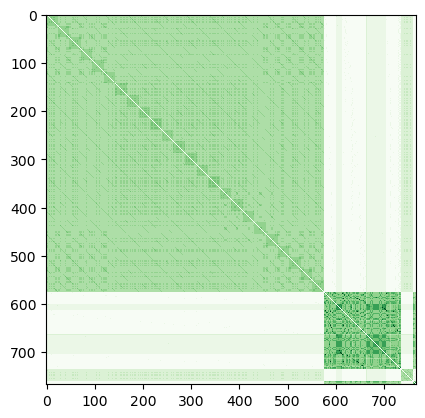

In [17]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

files = os.listdir("C:/Users/DSLab/Lab/DSL/ARC/data/training")
for i, f in enumerate(files) :
    file_path = "C:/Users/DSLab/Lab/DSL/ARC/data/training/" + f
    try:
        with open(file_path) as file:
            task = json.load(file)         
    except :
        print("file open error")
    print(f, " ", i + 1, "/", len(files))
    directory = "C:/Users/DSLab/Lab/DSL/" + f
    if not os.path.exists(directory):
        os.makedirs(directory)
    KG = Make_KG(task)
    
    for i, kg in enumerate(KG): 
        ## KG [[node_list, edge_list],[],[]]
        ## kg [node_list, edge_list]

        nodelist_save = [node.__str__() for node in kg[0]]

        print("preparing the image... : pair ", i + 1, "/", len(KG))
        result, count_edge = print_adj(kg)
        plt.size = (40,40)
        plt.imshow(count_edge, cmap='Greens', interpolation='nearest')
        img_name = "pair" + str(i + 1) + ".png"
        file_name = os.path.join(directory, img_name)
        plt.savefig(file_name)
        # plt.show()
        edge_list_name = "pair" + str(i + 1) + "edge_list" + ".txt"
        file_path_edge = os.path.join(directory, edge_list_name)

        json_edge = {}#
        for i, a in enumerate(result):#
            json_edge[i] = {}#
            for j, b in enumerate(a):#
                json_edge[i][j] = result[i][j]#

        json_node = {}
        for i, node in enumerate(kg[0]):
            json_node[i] = {}
            json_node[i]["type"] = node.type
            if isinstance(node, Vnode):
                json_node[i]["assign"] = "pair"
            else :
                if node.input == 1:
                    json_node[i]["assign"] = "input"
                else :
                    json_node[i]["assign"] = "output"
            if isinstance(node, Pnode):
                json_node[i]["composition"] = i
            elif isinstance(node, Onode) or isinstance(node, Gnode):
                json_node[i]["composition"] = [pnode.number for pnode in node.Pnode_list]
            elif isinstance(node, Vnode):
                json_node[i]["composition"] = [gnode.number for gnode in node.Gnode_list]

        #json_edge = json.dumps(json_edge)
        json_node = json.dumps(json_node)

        with open(file_path_edge, 'w') as f:
            f.write(str(result))
            #f.write(json_edge)
        node_list_name = "pair" + str(i + 1) + "node_list" + ".json"
        file_path_node = os.path.join(directory, node_list_name)
        with open(file_path_node, 'w') as f:
            #f.write(str(nodelist_save))
            f.write(json_node)
        

        print()

    print()
        

In [208]:
## solvers

def linear(input, target):
    As = [0,1,2,3,4,5, 1/2]
    Bs = [-4, -3, -2, -1, 0, 1, 2, 3, 4, 1/2]
    answer = set()
    for a in As:
        for b in Bs:
            if a * input + b == target:
                answer.add((a,b))
    return answer

def xnode_h (Xnode):
    if isinstance(Xnode, Pnode) or isinstance(Xnode, Vnode):
        return None
    return get_height(Xnode)

def xnode_w (Xnode):
    if isinstance(Xnode, Pnode) or isinstance(Xnode, Vnode):
        return None
    return get_width(Xnode)

def number_of_colorset(Xnode):
    if isinstance(Xnode, Pnode) or isinstance(Xnode, Vnode):
        return None
    return len(Xnode.color)

def node_size(Xnode):
    if isinstance(Xnode, Pnode) or isinstance(Xnode, Vnode):
        return None
    return get_number_of_nodes(Xnode)

def onode_count1(Xnode):
    if isinstance(Xnode, Gnode):
        count = 1
        for onode in Xnode.Onode_list:
            if onode.condition == ("single_color", "get_manhattan_dist") and onode.color != {0}:
                count += 1
        return count
    else :
        return None
    
def onode_count2(Xnode):
    if isinstance(Xnode, Gnode):
        count = 1
        for onode in Xnode.Onode_list:
            if onode.condition == ("multi_color", "get_polar_dist") and onode.color != {0}:
                count += 1
        return count
    else :
        return None
    
def onode_count3(Xnode):
    if isinstance(Xnode, Gnode):
        count = 1
        for onode in Xnode.Onode_list:
            if onode.condition == ("single_color", "get_polar_dist") and onode.color != {0}:
                count += 1
        return count
    else :
        return None
    
def onode_count4(Xnode):
    if isinstance(Xnode, Gnode):
        count = 1
        for onode in Xnode.Onode_list:
            if onode.condition == ("multi_color", "get_manhattan_dist") and onode.color != {0}:
                count += 1
        return count
    else :
        return None

In [221]:
get_int = [xnode_h, xnode_w, number_of_colorset, node_size, onode_count1, onode_count2, onode_count3, onode_count4]
def solver_function(Xnode, target):
    solver = set()
    for candi in get_int:
        i = candi(Xnode)
        if not isinstance(i, int):
            continue
        answer = linear(i, target)
        if len(answer) != 0:
            for ele in answer:
                temp = lambda n: candi(n) * ele[0] + ele[1] if not candi(n) == None else 0
                tag = (candi.__name__, ele[0], ele[1])
                solver.add((temp,tag))
    return solver
    

In [211]:
def extractor(KG, target_xnode):
    node_info = {}
    node_info["type"] = target_xnode.type
    node_info["properties"] = set()

    if isinstance(target_xnode, Gnode):
        node_info["definition"] = "Gnode"
        return node_info
    else :
        node_info["definition"] = target_xnode.condition

    edge_list = KG[1]
    edge_dict = {}
    # print("node type : ", type(target_xnode))

    for edge in edge_list:
        if target_xnode in edge.node_set and edge.node_set[0].input == 1 and edge.node_set[1].input == 1:
            if edge.tag[0] not in edge_dict.keys():
                edge_dict[edge.tag[0]] = 1
            else :
                edge_dict[edge.tag[0]] += 1
    max_size = 0
    min_size = 900
    unique = 1
    for node in KG[0]:
        if node.type == "Onode" and node.condition == target_xnode.condition and node.input == 1:
            if node.color == target_xnode.color and node != target_xnode:
                unique = 0
            max_size = max(max_size, get_number_of_nodes(node))
            min_size = min(max_size, get_number_of_nodes(node))
    if max_size <= get_number_of_nodes(target_xnode):
        node_info["properties"].add("max_size")
    if min_size >= get_number_of_nodes(target_xnode):
        node_info["properties"].add("min_size")
    if unique == 1:
        node_info["properties"].add("unique_color")

    if "is_ring" in edge_dict.keys():
        node_info["properties"].add("ring_shape")
    if "is_rectangle" in edge_dict.keys():
        node_info["properties"].add("rectangle_shape")
    if "is_square" in edge_dict.keys():
        node_info["properties"].add("square_shape")
    if "is_symmetric" in edge_dict.keys():
        node_info["properties"].add("symmetric")

    node_info["edge_list"] = edge_dict
    return node_info


In [212]:
from itertools import combinations
def specifer(KG, target_xnode):
    node_info = extractor(KG, target_xnode)
    if node_info["type"] == "Gnode":
        return ("get_Gnode",lambda n: True if n.type == "Gnode" else False)
    candi_node_list = []
    for n in KG[0]:
        if n.input  == 1 and (n.type == "Onode" or n.type == "Gnode") :
            candi_node_list.append(n)
    
    speic = []
    obj_def = lambda n: True if n.condition == node_info["definition"] else False
    speic.append(("obj_def", obj_def))
    
    for property in node_info["properties"]:
        temp_funtion = lambda n : True if property in extractor(KG, n)["properties"] else False
        speic.append((property, temp_funtion))


    all_combinations = []
    for r in range(1, len(speic) + 1):
        all_combinations.extend(combinations(speic, r))
    # all_combinations.sort(key=lambda x: len(x), reverse=True)
    # print("combination is done, number : ", len(all_combinations))
    # print(all_combinations)
    
    # print("size of node list :",len(candi_node_list))

    for i, combo in enumerate(all_combinations):
        # print(i + 1, "/", len(all_combinations), "checking")
        # for c in combo:
        #     print (c[0], end=", ")
        # print()
        t_node = []
        # print("len of combo is : ", len(combo))
        for n in candi_node_list:
            no = 0
            for f in combo :
                if f[1](n) == False:
                    no = 1
                    break
            if no == 0:
                t_node.append(n)
        # print("t_node is done")
        if len(t_node) == 1:
            # print("print from inside of",all_combinations[i])
            sol = lambda n : True if (c[1](n) == True for c in combo) else False
            tag = ""
            for c in combo:
                tag = tag + " " + c[0]
            return (tag, sol)
        else :
            # print("t_node is bigger then 1")
            continue
    # print("cannot specify")
    return None

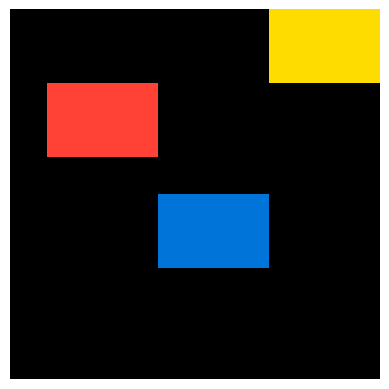

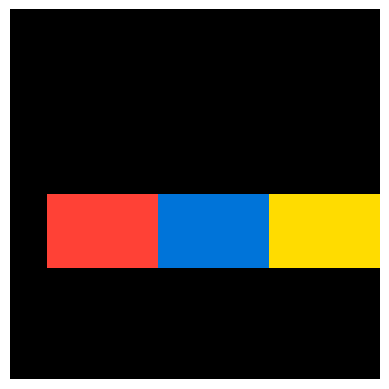

In [213]:
grid = task["train"][1]["input"]
Grid_to_Img(grid)
plt.show()
grid = task["train"][1]["output"]
Grid_to_Img(grid)

In [171]:
print(task)

{'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 4, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 4, 0, 4, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 7, 0, 0], [0, 0, 0, 0, 0, 7, 1, 7, 0], [0, 0, 0, 0, 0, 0, 7, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]}, {'input': [[0, 0, 0, 8, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 'output': [[0, 0, 0, 8, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 4, 0, 4, 0], [0, 0, 7, 0, 0, 0, 2, 0, 0], [0, 7, 1, 7, 0, 4, 0, 4, 0], [0, 0, 7, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 

In [180]:
def GridSize_pridictor (task):
    KG = Make_KG(task)
    pair_1 = KG[0]   
    for n in KG[0][0]:
        if isinstance(n, Gnode) and n.output == 1:
            target = (get_height(n), get_width(n))
    print("target for pair one : ", target)
    node_solver_h= set()
    node_solver_w= set()   ## w와 h는 따로따로 찾는다
    for n in pair_1[0]:   ## node들을 반복해서 적용함
        if isinstance(n, Onode) or isinstance(n, Gnode):
            if n.output == 1:
                continue
            ans_h = solver_function(n, target[0])    ## 해당 노드에서 solver를 적용해서 target이 되는 지 확인
            if ans_h != None:
                for a in ans_h:
                    node_solver_h.add((n, a))        ## 가능한 solver가 있다면 모두 저장 (node, (lambda, tag)) 형식으로 저장함
            ans_w = solver_function(n, target[1])
            if ans_w != None:
                for a in ans_w:
                    node_solver_w.add((n, a))
    print("#############################################")
    print("solvers : ", len(node_solver_h))
    for s in node_solver_h:
        print("type : ",s[0].type , "func : ", s[1][1])
        if isinstance(s[0], Gnode):
            print(s[1][0](s[0]))
    print("#############################################")

    solver_h = set()
    print("generating solvers ...")
    for i, s_h in enumerate(node_solver_h):
        progress = i / len(node_solver_h) * 100
        bar_width = int(progress)
        print('\r [%-*s] %.1f%%' % (100, '=' * bar_width, progress), end='')

        temp = specifer(KG[0], s_h[0])      ##########(tag, lambda)
        if temp != None:
            pass
        else :
            continue
        solver_h.add((temp, s_h[1]))

    print("solver num:", len(solver_h))
    

    for i in range(1, len(KG)):
        candi_node = []
        for n in KG[i][0]:
            if isinstance(n, Gnode) and n.output == 1:
                target_i = (get_height(n), get_width(n))
            if (isinstance(n, Gnode) or isinstance(n, Onode)) and n.input == 1:
                candi_node.append(n)
        print("num of candi : ", len(candi_node), " ", i)
        print("target: ",target_i[0])
        new_solver_h = set()
        for s in solver_h:    ##(temp, s_h[1]) = ((tag, lamdba), (lambda, tag))
            for n in candi_node:
                print("node is : ", n, " bool : ", s[0][1](n))
                print("tag for specifier", s[0][0])
                print("tag for solver", s[1][1])
                try:
                    print("height :", get_height(n))
                    print("target ? ", s[1][0](n))

                    if s[0][1](n) == True and s[1][0](n) == target_i[0]:
                        print("aaaaaaaaa")
                        new_solver_h.add(s)
                        break
                except :
                    pass
        solver_h = new_solver_h
        print("solver num:", len(solver_h))

    return solver_h

In [222]:
# KG = Make_KG(task)
# pair_1 = KG[0]   
# for n in KG[0][0]:
#     if isinstance(n, Gnode) and n.output == 1:
#         target = (get_height(n), get_width(n))
# print("target for pair one : ", target)
# node_solver_h= set()
# node_solver_w= set()   ## w와 h는 따로따로 찾는다
# for n in pair_1[0]:   ## node들을 반복해서 적용함
#     if isinstance(n, Onode) or isinstance(n, Gnode):
#         if n.output == 1:
#             continue
#         ans_h = solver_function(n, target[0])    ## 해당 노드에서 solver를 적용해서 target이 되는 지 확인
#         if ans_h != None:
#             for a in ans_h:
#                 node_solver_h.add((n, a))        ## 가능한 solver가 있다면 모두 저장 (node, (lambda, tag)) 형식으로 저장함
#         ans_w = solver_function(n, target[1])
#         if ans_w != None:
#             for a in ans_w:
#                 node_solver_w.add((n, a))
# print("#############################################")
# print("solvers : ", len(node_solver_h))
# for s in node_solver_h:
#     print("type : ",s[0].type , "func : ", s[1][1])
#     if isinstance(s[0], Gnode):
#         print(s[1][0](s[0]))
# print("#############################################")

# solver_h = set()
# print("generating solvers ...")
# for i, s_h in enumerate(node_solver_h):
#     progress = i / len(node_solver_h) * 100
#     bar_width = int(progress)
#     print('\r [%-*s] %.1f%%' % (100, '=' * bar_width, progress), end='')

#     temp = specifer(KG[0], s_h[0])      ##########(tag, lambda)
#     if temp != None:
#         pass
#     else :
#         continue
#     solver_h.add((temp, s_h[1]))

# print("solver num:", len(solver_h))


temp_solver = []
for s in solver_h:
    temp_solver.append(s)

for i in range(1, len(KG)):
    candi_node = []
    for n in KG[i][0]:
        if isinstance(n, Gnode) and n.output == 1:
            target_i = (get_height(n), get_width(n))
        if (isinstance(n, Gnode) or isinstance(n, Onode)) and n.input == 1:
            candi_node.append(n)
    print("num of candi : ", len(candi_node), " ", i)
    print("target: ",target_i)
    new_solver_h = set()
    for k, s in enumerate(temp_solver):    ##(temp, s_h[1]) = ((tag, lamdba), (lambda, tag))
        for j, n in enumerate(candi_node):
            print("num_of_solver", k,"/",len(temp_solver))
            print("num_of_none", j,"/",len(candi_node))

            print("node is : ", n, " bool : ")
            print(s[0][1](n))
            print("tag for specifier", s[0][0])
            print("tag for solver", s[1][1])
            print("target ? ", s[1][0](n))
            print("width :", get_height(n))
            if s[0][1](n) == False:
                continue
            if s[1][0](n) == target_i[0]:
                    print("aaaaaaaaa")
                    new_solver_h.add(s)
            # try:
            #     print("height :", get_height(n))
            #     print("target ? ", s[1][0](n))

            #     if s[0][1](n) == True and s[1][0](n) == target_i[0]:
            #         print("aaaaaaaaa")
            #         new_solver_h.add(s)
            #         break
            # except :
            #     pass
    temp_solver = new_solver_h
    print("solver num:", len(temp_solver))

print(temp_solver)

converting task to knowledge graph... 1 / 3
 [====================================================================================================] 100.0%
converting task to knowledge graph... 2 / 3
 [====================================================================================================] 100.0%
converting task to knowledge graph... 3 / 3
 [====================================================================================================] 100.0%
 
target for pair one :  (5, 10)
#############################################
solvers :  321
type :  Onode func :  ('xnode_h', 1, 3)
type :  Onode func :  ('xnode_w', 0.5, 4)
type :  Onode func :  ('xnode_h', 3, -1)
type :  Onode func :  ('xnode_h', 0.5, 4)
type :  Onode func :  ('xnode_h', 3, -1)
type :  Onode func :  ('xnode_w', 4, -3)
type :  Onode func :  ('node_size', 2, -3)
type :  Onode func :  ('xnode_h', 2, 1)
type :  Onode func :  ('xnode_w', 2, 1)
type :  Onode func :  ('number_of_colorset', 1, 4)
type :  Onode func :

In [177]:
task = {"train": [{"input": [[0, 2, 2, 0, 0, 0, 0, 0, 0, 0], [0, 2, 2, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 4, 4, 0, 1, 1, 0], [0, 0, 0, 0, 4, 4, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "output": [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 2, 0, 4, 4, 0, 1, 1, 0], [0, 2, 2, 0, 4, 4, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}, {"input": [[0, 0, 0, 0, 0, 0, 0, 4, 4, 4], [0, 0, 0, 0, 0, 0, 0, 4, 4, 4], [0, 2, 2, 2, 0, 0, 0, 0, 0, 0], [0, 2, 2, 2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "output": [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 2, 2, 1, 1, 1, 4, 4, 4], [0, 2, 2, 2, 1, 1, 1, 4, 4, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}, {"input": [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 1, 0, 2, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, 4, 0, 0, 0]], "output": [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 2, 0, 0, 4, 0, 0, 0], [0, 1, 0, 2, 0, 0, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}], "test": [{"input": [[0, 0, 0, 0, 0, 0, 0, 0, 2, 2], [0, 0, 0, 0, 0, 0, 0, 0, 2, 2], [0, 1, 1, 0, 0, 0, 0, 2, 0, 0], [0, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 4, 4, 0, 0, 0, 0], [0, 0, 0, 0, 4, 4, 0, 0, 0, 0], [0, 0, 0, 4, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "output": [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 4, 4, 0, 0, 2, 2], [0, 1, 1, 0, 4, 4, 0, 0, 2, 2], [1, 0, 0, 4, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}]}
GridSize_pridictor(task)

converting task to knowledge graph... 1 / 3
 [====================================================================================================] 100.0%
converting task to knowledge graph... 2 / 3
 [====================================================================================================] 100.0%
converting task to knowledge graph... 3 / 3
 [====================================================================================================] 100.0%
 
target for pair one :  (5, 10)
solvers :  261
type :  Onode func :  ('node_size', 1, 1)
type :  Onode func :  ('number_of_colorset', 1, 4)
type :  Onode func :  ('xnode_h', 2, -3)
type :  Onode func :  ('xnode_w', 1, -4)
type :  Gnode func :  ('onode_count3', 2, 3)
type :  Onode func :  ('xnode_h', 2, 1)
type :  Onode func :  ('number_of_colorset', 1, 4)
type :  Onode func :  ('xnode_h', 2, -3)
type :  Onode func :  ('number_of_colorset', 2, 3)
type :  Onode func :  ('xnode_w', 3, -4)
type :  Onode func :  ('xnode_h', 4, -3)
ty

set()

In [181]:
task = {"train": [{"input": [[0, 2, 2, 0, 0, 0, 0, 0, 0, 0], [0, 2, 2, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 4, 4, 0, 1, 1, 0], [0, 0, 0, 0, 4, 4, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "output": [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 2, 0, 4, 4, 0, 1, 1, 0], [0, 2, 2, 0, 4, 4, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}, {"input": [[0, 0, 0, 0, 0, 0, 0, 4, 4, 4], [0, 0, 0, 0, 0, 0, 0, 4, 4, 4], [0, 2, 2, 2, 0, 0, 0, 0, 0, 0], [0, 2, 2, 2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "output": [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 2, 2, 1, 1, 1, 4, 4, 4], [0, 2, 2, 2, 1, 1, 1, 4, 4, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}, {"input": [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 1, 0, 2, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, 4, 0, 0, 0]], "output": [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 2, 0, 0, 4, 0, 0, 0], [0, 1, 0, 2, 0, 0, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}], "test": [{"input": [[0, 0, 0, 0, 0, 0, 0, 0, 2, 2], [0, 0, 0, 0, 0, 0, 0, 0, 2, 2], [0, 1, 1, 0, 0, 0, 0, 2, 0, 0], [0, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 4, 4, 0, 0, 0, 0], [0, 0, 0, 0, 4, 4, 0, 0, 0, 0], [0, 0, 0, 4, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "output": [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 4, 4, 0, 0, 2, 2], [0, 1, 1, 0, 4, 4, 0, 0, 2, 2], [1, 0, 0, 4, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}]}
GridSize_pridictor(task)

converting task to knowledge graph... 1 / 3
 [====================================================================================================] 100.0%
converting task to knowledge graph... 2 / 3
 [====================================================================================================] 100.0%
converting task to knowledge graph... 3 / 3
 [====================================================================================================] 100.0%
 
target for pair one :  (5, 10)
#############################################
solvers :  261
type :  Onode func :  ('xnode_h', 4, -3)
type :  Onode func :  ('number_of_colorset', 1, 4)
type :  Onode func :  ('number_of_colorset', 3, 2)
type :  Onode func :  ('xnode_h', 1, 0)
type :  Onode func :  ('number_of_colorset', 3, 2)
type :  Onode func :  ('number_of_colorset', 4, 1)
type :  Onode func :  ('xnode_w', 2, -1)
type :  Onode func :  ('number_of_colorset', 5, 0)
type :  Onode func :  ('number_of_colorset', 1, 4)
type :  Gnode

Traceback (most recent call last):
  File "c:\Users\DSLab\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\DSLab\AppData\Local\Temp\ipykernel_14564\2177208075.py", line 2, in <module>
    GridSize_pridictor(task)
  File "C:\Users\DSLab\AppData\Local\Temp\ipykernel_14564\224706633.py", line 37, in GridSize_pridictor
    temp = specifer(KG[0], s_h[0])      ##########(tag, lambda)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\DSLab\AppData\Local\Temp\ipykernel_14564\2160070758.py", line 39, in specifer
    if f[1](n) == False:
       ^^^^^^^
  File "C:\Users\DSLab\AppData\Local\Temp\ipykernel_14564\2160070758.py", line 16, in <lambda>
    temp_funtion = lambda n : True if property in extractor(KG, n)["properties"] else False
                                                  ^^^^^^^^^^^^^^^^
  File "C:\Users\DSLab\AppData\Local\Temp\ipykernel_14564\2702584223.py", line -1, in e

In [173]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
files = os.listdir("C:/Users/DSLab/Lab/DSL/ARC/data/training")
f = files[29]
# f = files[0]
print(f)
file_path = "C:/Users/DSLab/Lab/DSL/ARC/data/training/" + f
try:
    with open(file_path) as file:
        task = json.load(file)         
except :
    print("file open error")
directory = "C:/Users/DSLab/Lab/DSL/" + f
if not os.path.exists(directory):
    os.makedirs(directory)
KG = Make_KG(task)

pair_1 = KG[0]   
for n in KG[0][0]:        ## target 찾는 과정
    if isinstance(n, Gnode) and n.output == 1:
        target = (get_height(n), get_width(n))
print("target : ", target)

for n in KG[1][0]:        ## target 찾는 과정
    if isinstance(n, Gnode) and n.output == 1:
        target = (get_height(n), get_width(n))
print("target 2 :", target)


node_solver_h= set()
node_solver_w= set()   ## w와 h는 따로따로 찾는다
for n in pair_1[0]:   ## node들을 반복해서 적용함
    if isinstance(n, Onode) or isinstance(n, Gnode):
        if n.output == 1:
            continue
        ans_h = solver_function(n, target[0])    ## 해당 노드에서 solver를 적용해서 target이 되는 지 확인
        if ans_h != None:
            for a in ans_h:
                node_solver_h.add((n, a))        ## 가능한 solver가 있다면 모두 저장 (node, (lambda, tag)) 형식으로 저장함
        ans_w = solver_function(n, target[1])
        if ans_w != None:
            for a in ans_w:
                node_solver_w.add((n, a))

print("h : ", len(node_solver_h))
print("w : ",len(node_solver_w))


# for s in node_solver_h:
#     print("node :", s[0], end=" ")
#     # print(s[1][0](s[0]))    
#     print("solver :", s[1][1])


# num = len(node_solver_h)
# for i, s in enumerate(node_solver_h):
#     progress = (i + 1) / num * 100
#     bar_width = int(progress)
#     print('\r [%-*s] %.1f%%' % (100, '=' * bar_width, progress), end='')

#     if s[0].type == "Vnode":
#         print(s)
#         continue
#     node_info = extractor(pair_1, s[0])






# from collections import defaultdict

# # 각 b 값의 개수를 카운트하는 딕셔너리 생성
# c_counts = defaultdict(int)
# for a, (b, c) in node_solver_h:
#     c_counts[c[0]] += 1

# print(c_counts)


## s[0] = node
## s[1] = (lambda, tag)
## s[1][0] = lambda
## s[1][1] = tag

# for s in node_solver_w:
#     print("node :", s[0], end=" ")
#     # print(s[1][0](s[0]))
#     print("solver :", s[1][1])



for s in node_solver_h:
    if isinstance(s[0], Gnode):
        print(s[1][1])
        print(s[0])
        print(s[1][0](s[0]))

1caeab9d.json
converting task to knowledge graph... 1 / 3
 [====================================================================================================] 100.0%
converting task to knowledge graph... 2 / 3
 [====================================================================================================] 100.0%
converting task to knowledge graph... 3 / 3
 [====================================================================================================] 100.0%
 
target :  (5, 10)
target 2 : (10, 10)
h :  122
w :  122
('xnode_h', 2, 0)
Gnode: N:1, I
10
('onode_count4', 3, -2)
Gnode: N:1, I
10
('onode_count1', 2, 2)
Gnode: N:1, I
10
('onode_count4', 2, 2)
Gnode: N:1, I
10
('number_of_colorset', 3, -2)
Gnode: N:1, I
10
('onode_count1', 3, -2)
Gnode: N:1, I
10
('xnode_w', 1, 0)
Gnode: N:1, I
10
('number_of_colorset', 2, 2)
Gnode: N:1, I
10


(['Pnode: N:0, O', 'Onode: N:{0, 21, 22}, O'], ('get_onode', ('single_color', 'get_polar_distance')))
(['Pnode: N:22, O', 'Onode: N:{0, 21, 22}, O'], ('get_onode', ('single_color', 'get_polar_distance')))
(['Pnode: N:21, O', 'Onode: N:{0, 21, 22}, O'], ('get_onode', ('single_color', 'get_polar_distance')))
(['Pnode: N:2, O', 'Onode: N:{1, 2}, O'], ('get_onode', ('single_color', 'get_polar_distance')))
(['Pnode: N:1, O', 'Onode: N:{1, 2}, O'], ('get_onode', ('single_color', 'get_polar_distance')))
(['Pnode: N:24, O', 'Onode: N:{24, 3, 23}, O'], ('get_onode', ('single_color', 'get_polar_distance')))
(['Pnode: N:3, O', 'Onode: N:{24, 3, 23}, O'], ('get_onode', ('single_color', 'get_polar_distance')))
(['Pnode: N:23, O', 'Onode: N:{24, 3, 23}, O'], ('get_onode', ('single_color', 'get_polar_distance')))
(['Pnode: N:4, O', 'Onode: N:{26, 4}, O'], ('get_onode', ('single_color', 'get_polar_distance')))
(['Pnode: N:26, O', 'Onode: N:{26, 4}, O'], ('get_onode', ('single_color', 'get_polar_distan

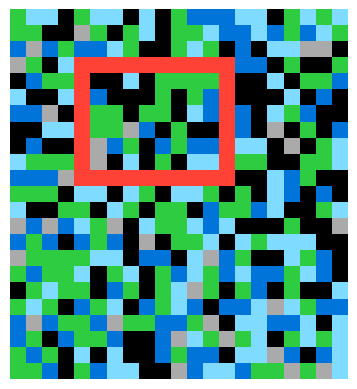

In [162]:
task = {"train": [{"input": [[3, 8, 8, 0, 3, 8, 8, 0, 8, 0, 3, 1, 1, 1, 8, 8, 0, 3, 8, 3, 8], [3, 3, 0, 0, 5, 3, 0, 3, 8, 0, 3, 3, 8, 1, 1, 8, 1, 3, 1, 8, 3], [1, 5, 1, 3, 1, 1, 8, 3, 0, 0, 3, 8, 3, 0, 1, 0, 8, 8, 5, 5, 0], [5, 3, 0, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 3, 0, 0, 3], [0, 1, 3, 3, 2, 0, 0, 8, 0, 3, 3, 3, 3, 2, 0, 0, 8, 0, 3, 3, 1], [8, 0, 0, 8, 2, 1, 0, 0, 0, 3, 0, 3, 1, 2, 0, 0, 0, 8, 0, 1, 0], [1, 1, 5, 0, 2, 3, 3, 0, 3, 3, 0, 8, 1, 2, 1, 0, 8, 3, 1, 0, 0], [0, 0, 8, 8, 2, 3, 3, 5, 1, 0, 3, 0, 0, 2, 1, 0, 5, 0, 3, 0, 1], [0, 1, 0, 0, 2, 5, 1, 3, 0, 1, 3, 1, 1, 2, 8, 8, 0, 5, 0, 3, 8], [8, 3, 3, 3, 2, 5, 0, 8, 0, 3, 0, 8, 8, 2, 3, 3, 0, 0, 3, 3, 8], [1, 1, 1, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 8, 1, 3, 0, 0], [3, 3, 3, 0, 8, 8, 0, 8, 3, 0, 8, 8, 3, 0, 3, 0, 8, 1, 0, 1, 0], [8, 0, 0, 3, 3, 0, 8, 3, 0, 3, 3, 0, 1, 3, 3, 1, 8, 0, 0, 3, 8], [5, 1, 5, 1, 8, 3, 5, 0, 8, 3, 3, 8, 1, 8, 0, 0, 0, 3, 0, 0, 5], [1, 3, 1, 0, 1, 3, 1, 0, 5, 0, 3, 3, 8, 0, 8, 3, 8, 8, 8, 0, 0], [5, 3, 3, 3, 3, 8, 8, 0, 1, 1, 0, 8, 5, 1, 3, 0, 0, 8, 3, 1, 0], [3, 1, 3, 3, 8, 0, 3, 8, 0, 3, 1, 8, 3, 1, 8, 1, 1, 3, 8, 1, 0], [0, 3, 8, 3, 3, 0, 1, 3, 0, 3, 8, 5, 3, 0, 3, 1, 0, 3, 0, 0, 8], [3, 8, 3, 0, 1, 3, 8, 0, 1, 3, 8, 1, 0, 1, 1, 8, 5, 8, 3, 1, 1], [1, 5, 1, 3, 3, 1, 5, 3, 3, 1, 1, 3, 5, 0, 8, 8, 1, 1, 8, 0, 8], [1, 3, 0, 1, 3, 3, 1, 0, 0, 1, 5, 8, 3, 5, 3, 8, 0, 3, 8, 3, 8], [3, 1, 3, 0, 8, 0, 8, 0, 0, 1, 3, 1, 1, 0, 8, 8, 5, 1, 0, 1, 8], [3, 3, 1, 0, 3, 1, 8, 8, 0, 0, 5, 1, 8, 8, 1, 3, 3, 5, 3, 5, 8]], "output": [[0, 0, 8, 0, 3, 3, 3, 3], [1, 0, 0, 0, 3, 0, 3, 1], [3, 3, 0, 3, 3, 0, 8, 1], [3, 3, 5, 1, 0, 3, 0, 0], [5, 1, 3, 0, 1, 3, 1, 1], [5, 0, 8, 0, 3, 0, 8, 8]]}, {"input": [[0, 6, 9, 6, 6, 0, 6, 3, 6, 9, 6, 6, 6, 9, 9, 0], [9, 9, 0, 6, 6, 0, 0, 9, 3, 6, 6, 6, 9, 9, 0, 6], [6, 0, 9, 0, 0, 6, 0, 6, 6, 0, 3, 0, 0, 6, 0, 0], [9, 6, 6, 9, 9, 9, 6, 3, 6, 9, 9, 6, 6, 3, 6, 6], [6, 6, 0, 0, 6, 6, 9, 0, 0, 3, 0, 0, 0, 0, 0, 9], [9, 9, 6, 0, 0, 9, 0, 0, 3, 9, 3, 0, 0, 0, 9, 0], [3, 6, 4, 4, 4, 4, 4, 6, 0, 0, 0, 9, 0, 0, 0, 9], [9, 0, 4, 3, 3, 0, 4, 0, 0, 6, 0, 0, 9, 6, 9, 3], [9, 0, 4, 9, 3, 9, 4, 9, 0, 0, 3, 9, 0, 0, 9, 3], [6, 9, 4, 6, 6, 0, 4, 3, 9, 6, 0, 6, 0, 9, 3, 0], [3, 3, 4, 9, 0, 0, 4, 9, 0, 6, 0, 0, 0, 6, 0, 0], [0, 0, 4, 6, 3, 9, 4, 6, 0, 9, 0, 9, 0, 0, 0, 0], [9, 9, 4, 4, 4, 4, 4, 9, 9, 0, 9, 9, 0, 0, 0, 6]], "output": [[3, 3, 0], [9, 3, 9], [6, 6, 0], [9, 0, 0], [6, 3, 9]]}, {"input": [[2, 5, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 5, 3, 5], [2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 5, 3, 0, 3, 2, 0, 5], [0, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 0, 0], [2, 0, 2, 8, 0, 0, 5, 3, 3, 3, 2, 2, 5, 0, 8, 2, 5, 5], [5, 0, 3, 8, 3, 0, 0, 5, 5, 5, 5, 2, 0, 5, 8, 3, 3, 3], [0, 5, 5, 8, 3, 5, 0, 2, 0, 3, 0, 5, 3, 0, 8, 0, 2, 5], [5, 2, 2, 8, 3, 2, 5, 5, 0, 5, 3, 0, 5, 0, 8, 0, 0, 0], [0, 0, 0, 8, 5, 2, 5, 2, 5, 0, 2, 2, 2, 2, 8, 2, 0, 5], [5, 0, 5, 8, 0, 5, 2, 5, 0, 0, 0, 0, 3, 3, 8, 0, 0, 5], [3, 0, 0, 8, 2, 3, 2, 3, 0, 0, 5, 0, 5, 0, 8, 3, 2, 0], [3, 5, 0, 8, 3, 2, 5, 0, 5, 0, 0, 0, 5, 5, 8, 0, 0, 2], [3, 3, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 2, 0], [5, 0, 0, 3, 0, 3, 3, 5, 2, 5, 0, 0, 0, 0, 0, 5, 0, 0], [2, 5, 2, 5, 2, 2, 0, 0, 0, 5, 2, 0, 2, 0, 3, 0, 3, 0], [0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 3, 3, 2, 0, 2, 5, 2, 5], [3, 0, 0, 0, 0, 5, 3, 0, 0, 0, 2, 2, 5, 0, 2, 3, 2, 0], [0, 0, 2, 5, 0, 5, 0, 3, 0, 0, 0, 0, 2, 3, 3, 5, 2, 3]], "output": [[0, 0, 5, 3, 3, 3, 2, 2, 5, 0], [3, 0, 0, 5, 5, 5, 5, 2, 0, 5], [3, 5, 0, 2, 0, 3, 0, 5, 3, 0], [3, 2, 5, 5, 0, 5, 3, 0, 5, 0], [5, 2, 5, 2, 5, 0, 2, 2, 2, 2], [0, 5, 2, 5, 0, 0, 0, 0, 3, 3], [2, 3, 2, 3, 0, 0, 5, 0, 5, 0], [3, 2, 5, 0, 5, 0, 0, 0, 5, 5]]}], "test": [{"input": [[0, 0, 0, 8, 1, 1, 8, 0, 0, 8, 0, 8, 0, 0, 0, 8], [0, 1, 0, 8, 8, 1, 0, 1, 1, 2, 8, 1, 1, 2, 0, 2], [0, 0, 8, 8, 1, 1, 8, 8, 1, 1, 8, 0, 8, 0, 0, 1], [1, 0, 1, 0, 8, 0, 1, 8, 1, 0, 1, 1, 8, 8, 8, 0], [8, 0, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2], [1, 0, 8, 3, 2, 0, 8, 1, 1, 1, 0, 1, 0, 3, 0, 0], [0, 8, 8, 3, 8, 1, 0, 8, 2, 8, 1, 2, 8, 3, 1, 8], [1, 0, 8, 3, 8, 2, 0, 2, 0, 1, 1, 8, 1, 3, 8, 8], [0, 8, 0, 3, 0, 1, 8, 8, 1, 1, 8, 1, 8, 3, 2, 1], [1, 0, 0, 3, 0, 1, 8, 8, 0, 8, 0, 2, 0, 3, 8, 1], [0, 8, 8, 3, 0, 8, 8, 2, 8, 8, 8, 8, 8, 3, 8, 8], [1, 1, 1, 3, 8, 0, 2, 0, 0, 0, 0, 8, 8, 3, 8, 0], [1, 8, 0, 3, 0, 2, 8, 8, 1, 2, 0, 0, 2, 3, 8, 1], [8, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2], [8, 1, 0, 0, 0, 0, 8, 8, 0, 1, 2, 8, 8, 8, 1, 8], [8, 1, 0, 0, 1, 1, 8, 0, 1, 2, 8, 1, 0, 1, 2, 0], [8, 0, 8, 2, 8, 0, 8, 2, 0, 1, 8, 1, 8, 1, 8, 8]], "output": [[2, 0, 8, 1, 1, 1, 0, 1, 0], [8, 1, 0, 8, 2, 8, 1, 2, 8], [8, 2, 0, 2, 0, 1, 1, 8, 1], [0, 1, 8, 8, 1, 1, 8, 1, 8], [0, 1, 8, 8, 0, 8, 0, 2, 0], [0, 8, 8, 2, 8, 8, 8, 8, 8], [8, 0, 2, 0, 0, 0, 0, 8, 8], [0, 2, 8, 8, 1, 2, 0, 0, 2]]}]}
grid = task["train"][0]["input"]
Grid_to_Img(grid)

edge_list = create_edge_list()
node_list = Make_NodeList(grid)

temp_list, edge_list = Make_Onode(node_list, True, get_polar_distance, edge_list)
concat_list = Concat_node_list(node_list, temp_list)
temp_list, edge_list = Make_Onode(node_list, False, get_polar_distance, edge_list)
concat_list = Concat_node_list(concat_list, temp_list)

temp_list, edge_list = Make_Onode(node_list, True, get_manhattan_dist, edge_list)
concat_list = Concat_node_list(concat_list, temp_list)
temp_list, edge_list = Make_Onode(node_list, False, get_manhattan_dist, edge_list)
concat_list = Concat_node_list(concat_list, temp_list)

temp_list, edge_list = Make_Onode(node_list, True, None, edge_list)
concat_list = Concat_node_list(concat_list, temp_list)
temp_list, edge_list = Make_Onode(node_list, False, None, edge_list)
concat_list = Concat_node_list(concat_list, temp_list)

node_list = concat_list

temp_list = Make_edge_list(node_list, is_ring)
edge_list = Concat_edge_list( edge_list, temp_list)


for edge in edge_list:
    print(edge)  

In [ ]:
task = {"train": [{"input": [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], "output": [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 4, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 4, 0, 4, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 7, 0, 0], [0, 0, 0, 0, 0, 7, 1, 7, 0], [0, 0, 0, 0, 0, 0, 7, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]}, {"input": [[0, 0, 0, 8, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], "output": [[0, 0, 0, 8, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 4, 0, 4, 0], [0, 0, 7, 0, 0, 0, 2, 0, 0], [0, 7, 1, 7, 0, 4, 0, 4, 0], [0, 0, 7, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 7, 0, 0], [4, 0, 4, 0, 0, 7, 1, 7, 0], [0, 2, 0, 0, 0, 0, 7, 0, 0], [4, 0, 4, 0, 0, 0, 0, 0, 0]]}, {"input": [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 6, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], "output": [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 4, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 4, 0, 4, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 6, 0, 0], [0, 0, 0, 7, 0, 0, 0, 0, 0], [0, 0, 7, 1, 7, 0, 0, 0, 0], [0, 0, 0, 7, 0, 0, 0, 0, 0]]}], "test": [{"input": [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 8, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 6, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], "output": [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 7, 0, 0], [0, 4, 0, 4, 0, 7, 1, 7, 0], [0, 0, 2, 0, 0, 0, 7, 0, 0], [0, 4, 0, 4, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 8, 0, 0, 0], [0, 0, 0, 0, 0, 0, 4, 0, 4], [0, 6, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 4, 0, 4]]}]}
grid = task["train"][0]["output"]
Grid_to_Img(grid)

edge_list = create_edge_list()
node_list = Make_NodeList(grid)

temp_list, edge_list = Make_Onode(node_list, True, get_polar_distance, edge_list)
concat_list = Concat_node_list(node_list, temp_list)
temp_list, edge_list = Make_Onode(node_list, False, get_polar_distance, edge_list)
concat_list = Concat_node_list(concat_list, temp_list)

temp_list, edge_list = Make_Onode(node_list, True, get_manhattan_dist, edge_list)
concat_list = Concat_node_list(concat_list, temp_list)
temp_list, edge_list = Make_Onode(node_list, False, get_manhattan_dist, edge_list)
concat_list = Concat_node_list(concat_list, temp_list)

temp_list, edge_list = Make_Onode(node_list, True, None, edge_list)
concat_list = Concat_node_list(concat_list, temp_list)
temp_list, edge_list = Make_Onode(node_list, False, None, edge_list)
concat_list = Concat_node_list(concat_list, temp_list)

node_list = concat_list

for node in node_list:
    if isinstance(node, Onode):
        print(node.Pnode_list)  